Mark Searle, 3DGeo Group, Heidelberg University

February 2022

***

# Final workflow for NIBIO Application - Simulating on a Forest Plot and Annotating


### Input data

Please provide the desired input in the cell below.

For the point cloud, please subsample it using [CloudCompare](www.cloudcompare.org) using the "space" option and a value of 2cm. We will be voxelising with a voxel size of 2cm also.

In [1]:
# Number identifier for the plot
# (will be used to name the scene and survey files)
plot_number = 2

# Input point cloud to be processed (filename without backslashes)
data = r"G:/ws_21_22/praktikum/NIBIO_data/annotated_plots/plot_13_annotated.las"

# Flight Altidude (m.a.s.l.) NOT ABOVE POINT CLOUD!! 
# Check height of point cloud before setting.
altitude = 400

# Distance between two flight strips (m)
flight_spacing = 100

# Speed of the flight (m/s)
flight_speed = 25

## 1. Creating the Sceneparts
First, we compute a digital terrain model (DTM), which we will model in HELIOS++ separately from the trees. We use the [python extension](https://github.com/PDAL/python) of the open source library [PDAL](https://pdal.io/) (Point Data Abstraction Library) to create the DTM.

In [2]:
import pdal
from annotate import *
import os

First, we define our filenames.

In [3]:
data_classified = data.replace(".las", "_classified.las")
dtm_output = data.replace(".las", "_dtm_50cm.tif")
vegetation_output = data.replace(".las", "_vegetation.las")

We start by classifying the point cloud into ground and non-ground points using the Simple Morphological Filter (SMRF) (see also [Pingel et al. 2013](https://doi.org/10.1016/j.isprsjprs.2012.12.002)).

In [4]:
json_classification = """[
    "%s",
    {
        "type":"filters.smrf",
        "ignore":"Classification[7:7]",
        "window":33,
        "slope":0.2,
        "threshold":0.5,
        "cell":1.0
    },
    {
        "type":"filters.outlier",
        "method":"statistical",
        "mean_k":8,
        "multiplier":3.0
    },
    {
        "type":"writers.las",
        "filename": "%s",
        "compression":"false"
    }
]"""

In [5]:
pipeline = pdal.Pipeline(json_classification % (data, data_classified))
exe = pipeline.execute()

Then, we use only the ground points (class 2, according to the ASPRS Standard point classes of the [LAS format specification](http://www.asprs.org/wp-content/uploads/2019/07/LAS_1_4_r15.pdf), p. 19, Table 9) to create a DTM of 0.5 m resolution.

In [6]:
json_dtm = """[
    "%s",
    {
        "type":"filters.range",
        "limits":"Classification[2:2]"
    },
    {
        "type":"writers.gdal",
        "filename": "%s",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "resolution":1.0,
        "window_size":8
    }
]"""

In [7]:
pipeline = pdal.Pipeline(json_dtm % (data_classified, dtm_output))
exe = pipeline.execute()

We also want to export the non-ground points (= vegetation points) to a las file.

In [8]:
json_vegetation = """[
    "%s",
    {
        "type":"filters.range",
        "limits":"Classification[0:1]"
    },
    {
        "type":"writers.las",
        "filename": "%s",
        "compression":"false"
    }
]"""

In [9]:
pipeline = pdal.Pipeline(json_vegetation % (data_classified, vegetation_output))
exe = pipeline.execute()

Now we have the files needed to build our individual **sceneparts**, we will split the files covering the entire AOI into smaller tiles which we will simulate on individually to reduce memory consuption.

## 2. Writing the Scenes and Surveys

In order to split the AOI up into various tiles, we will first determine our trajectory.

**Note: From this point on the notebook needs to be located in the HELIOS++ root folder in order to work!**

The various components of our simulation will be written to folders named `outfolder` within the helios directory. The exact output locations are as follows:

surveys: `helios_dir/data/surveys/outfolder`

scenes: `helios_dir/data/scenes/outfolder`

sceneparts: `helios_dir/data/sceneparts/outfolder`

In [10]:
from pathlib import Path, PurePath
import shutil

outfolder = 'NIBIO_tiles'

scene_folder = Path('data/scenes/', outfolder)
scenepart_folder = Path('data/sceneparts/', outfolder)
survey_folder = Path('data/surveys/', outfolder)
if not scene_folder.exists():
    Path.mkdir(scene_folder)
if not scenepart_folder.exists():
    Path.mkdir(scenepart_folder)
if not survey_folder.exists():
    Path.mkdir(survey_folder)

For this we calculate the center of the plot with laspy and plan our survey around this point. 

In [11]:
import laspy

In [12]:
with laspy.open(vegetation_output) as f:
        header = f.header
        extents = [header.max, header.min]
central_point = [extents[1][0] + (extents[0][0]-extents[1][0])/2, 
                 extents[1][1] + (extents[0][1]-extents[1][1])/2]

We will fly along the Y axis with an offset of `flight_spacing/2` meters in either direction of the X axis.

In [13]:
waypoint1 = [central_point[0]+(flight_spacing/2), extents[1][1]]
waypoint2 = [central_point[0]+(flight_spacing/2), extents[0][1]]
waypoint3 = [central_point[0]-(flight_spacing/2), extents[0][1]]
waypoint4 = [central_point[0]-(flight_spacing/2), extents[1][1]]

We can check the trajectory visually here using matplotlib.

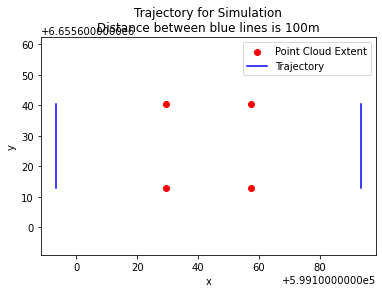

In [14]:
import matplotlib.pyplot as plt

plt.title('Trajectory for Simulation\nDistance between blue lines is {}m'.format(flight_spacing))
plt.scatter([extents[0][0], extents[0][0], extents[1][0], extents[1][0]], [extents[0][1], extents[1][1], extents[0][1], extents[1][1]], c='red', label='Point Cloud Extent')
plt.plot([waypoint1[0], waypoint2[0]], [waypoint1[1], waypoint2[1]], c='blue', label='Trajectory')
plt.plot([waypoint3[0], waypoint4[0]], [waypoint3[1], waypoint4[1]], c='blue')
plt.legend()
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Using these waypoints and the following scanner settings we can now write our survey and scene files.

**Change values as needed!**

In [15]:
# Scanner platform
platform = "sr22"

# Scanner id as specified in data/scanners_als.xml
scanner = "riegl_vux-240"

# Scanner settings
scan_angle = 37.5
pulse_freq = 1800000
scan_freq = 300

# Number of tile to split the AOI into.
# Should be adjusted according to number of points in input point cloud.
num_tiles = 5

scanner_config = [platform, scanner, scan_angle, 
                  pulse_freq, scan_freq, altitude, flight_speed]
trajectory = [waypoint1, waypoint2, waypoint3, waypoint4]

To split the AOI into tiles and create surveys and scenes for each tile we will use the function `create_tiles` from the file `annotate.py`.

In [16]:
create_tiles(plot_number, num_tiles, outfolder, vegetation_output, dtm_output,
             extents, trajectory, scanner_config)

Tile height 5.566000000014901m
Laying down tile number 1...
[[599193.365, 6655612.71, 400, 'true'], [599193.365, 6655618.276, 400, 'false'], [599093.365, 6655618.276, 400, 'true'], [599093.365, 6655612.71, 400, 'false']]
Tile successfully layed.
Writing survey file..
Writing scene file...
Laying down tile number 2...
[[599193.365, 6655618.276, 400, 'true'], [599193.365, 6655623.842, 400, 'false'], [599093.365, 6655623.842, 400, 'true'], [599093.365, 6655618.276, 400, 'false']]
Tile successfully layed.
Writing survey file..
Writing scene file...
Laying down tile number 3...
[[599193.365, 6655623.842, 400, 'true'], [599193.365, 6655629.408, 400, 'false'], [599093.365, 6655629.408, 400, 'true'], [599093.365, 6655623.842, 400, 'false']]
Tile successfully layed.
Writing survey file..
Writing scene file...
Laying down tile number 4...
[[599193.365, 6655629.408, 400, 'true'], [599193.365, 6655634.974, 400, 'false'], [599093.365, 6655634.974, 400, 'true'], [599093.365, 6655629.408, 400, 'false

As seen in the output, the function `create_tiles` wrote a scene xml, survey xml and sceneparts corresponding to each of the generated tiles. These are the ingredients we need to execute HELIOS++ simulations.

## 4. Running the Simulations

Next, we need to run each of the simulations that we just configured. There is a function in `annotate.py` called `sim_iter` that will do this for us.

1. As a test to check whether pyhelios is working correctly, we can attempt to import it first.

In [17]:
import pyhelios

2. Now let's run the simulations, this is done by giving `sim_iter` the number of iterations we want to perform and the template for the survey name:

`data/surveys/outfolder/px_t{}_survey.xml`

If nothing was changed  in the `create_tiles` function, the survey name template will be as specified in the following cell.

**We can watch the HELIOS++ command line output in the Anaconda Prompt.**

In [33]:
survey_name_template = 'p{}_'.format(plot_number) + 't{}_survey.xml'
outfolders = sim_iter(num_tiles, str(Path(survey_folder, survey_name_template)))

Simulation has started!
Survey Name: plot_2_tile_1
Scanner: riegl_vux-240 Power: 4.000000 W Divergence: 0.350000 mrad Wavelength: 1064 nm Visibility: 23.000000 km
Simulation has started!
Survey Name: plot_2_tile_2
Scanner: riegl_vux-240 Power: 4.000000 W Divergence: 0.350000 mrad Wavelength: 1064 nm Visibility: 23.000000 km
Simulation has started!
Survey Name: plot_2_tile_3
Scanner: riegl_vux-240 Power: 4.000000 W Divergence: 0.350000 mrad Wavelength: 1064 nm Visibility: 23.000000 km
Simulation has started!
Survey Name: plot_2_tile_4
Scanner: riegl_vux-240 Power: 4.000000 W Divergence: 0.350000 mrad Wavelength: 1064 nm Visibility: 23.000000 km
Simulation has started!
Survey Name: plot_2_tile_5
Scanner: riegl_vux-240 Power: 4.000000 W Divergence: 0.350000 mrad Wavelength: 1064 nm Visibility: 23.000000 km


## 5. Merge the Output from the different tiles.

The outputs of the simulations for each tile have ended up in seperate folders within the `helios_dir/output/Survey Playback/` folder. In order to perform the annotation transfer we must merge them into one .las file.

We will do this using [LAStools](https://lastools.github.io/), specifically the executable `lasmerge.exe`.

**Please assign the location of your** `lasmerge.exe` **to the variable** `lasmerge` **below.**

You can also specify an output file name and location.

In [34]:
lasmerge = r"G:\LAStools\bin\lasmerge.exe"
merge_location = r'output\Survey Playback\plot_{}_merged\plot_{}.las'.format(
    plot_number, plot_number)
if not Path(os.path.dirname(merge_location)).exists():
    Path.mkdir(Path(os.path.dirname(merge_location)))

As input for lasmerge we'll write a .txt file containing all of the filepaths of the files we want to merge.

In [35]:
to_merge = open('merge_list.txt', 'w')
for path in outfolders:
    for file in os.listdir(os.path.dirname(path)):
        if file.endswith('.las'):
            to_merge.write(os.path.join(os.getcwd(), os.path.dirname(path), file))
            to_merge.write('\n')
to_merge.close()

Now we can execute lasmerge with a command line call. We'll print the output in case anything goes wrong. If there's no output the program will have run successfully.

In [36]:
print(os.popen(r'"{}" -lof merge_list.txt -o "{}"'.format(lasmerge, merge_location)).read())

## 6. Annotate the Simulated Point Cloud

Now that we have our simulated point cloud we can perform our nearest neighbor annotation to transfer the annotations from the original input point cloud to the simulated one.

To open the point clouds we will use laspy.

In [37]:
import laspy
import numpy as np

Open both the input and clouds and read data.

In [38]:
i_point_format, lasi, header, input = open_las(data)
o_point_format, laso, header_unan, unannotated = open_las(merge_location)

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time', 'treeID', 'treeSP']
['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'echo_width', 'fullwaveIndex', 'hitObjectId', 'heliosAmplitude']


The annotated .las file will be written to the same folder as the merged point cloud produced by merging the output from the simulations.

In [39]:
annotated_name = merge_location.replace('.las', '_annotated.las')

For the nearest neighbor analysis we will use the python library sklearn, specifically the funciton KDTree.

In [40]:
from sklearn.neighbors import KDTree
import time

Compute kdtree and perform analysis. k = 1 to find only first nearest neighbor.

In [41]:
kdt_start = time.time()
kdt = KDTree(input[:3, :].transpose(), leaf_size=30, metric='euclidean')
kdt_calc_end = time.time()
query = kdt.query(unannotated.transpose(), k=1, return_distance=False)
kdt_end = time.time()

print('Time taken for setting up kdtree: {}s.'.format(kdt_calc_end-kdt_start))
print('Time taken for total analysis: {}s'.format(kdt_end-kdt_start))

Time taken for setting up kdtree: 12.694929361343384s.
Time taken for total analysis: 33.69055771827698s


Get values of tree id and species from query result

In [42]:
tree_spid = [[input[3, point[0]], input[4, point[0]]] for point in query]
tree_spid = np.array(tree_spid)

Create new laspy file for output point cloud. Copy of header from point cloud to be annotated and add extra dimensions to output point cloud.

In [43]:
annotated = laspy.LasData(header_unan)

annotated.add_extra_dim(laspy.ExtraBytesParams(
    name="treeSP",
    type=np.uint64,
    description="tree species"
))
annotated.add_extra_dim(laspy.ExtraBytesParams(
    name="treeID",
    type=np.uint64,
    description="tree id"
))

Copy point values from point cloud to be annotated to output point cloud.

In [44]:
to_copy = list(o_point_format.dimension_names)
to_copy.remove('treeID')
to_copy.remove('treeSP')
for dimension in to_copy:
    annotated[dimension] = laso[dimension]

Add new columns to output point cloud and write new las data to file.

In [45]:
annotated.treeSP = np.array(tree_spid[:,0])
annotated.treeID = np.array(tree_spid[:,1])

annotated.write(annotated_name)

print('LAS file written to {}'.format(merge_location))

LAS file written to output\Survey Playback\plot_2_merged\plot_2.las


Done! Annotated point cloud is located at filepath above.